In [1]:
import scipy
from scipy.stats import wilcoxon, ttest_rel, ttest_ind, ttest_1samp, mannwhitneyu, spearmanr, pearsonr
import scipy.io
import scipy.io.wavfile
import numpy as np
import matplotlib

In [78]:
get_ipython().run_line_magic('cd', '/home/mkc/src/amplitude-modulation-analysis-module')
from am_analysis import am_analysis as ama
mpl=matplotlib.pyplot

mod_feat = 'power_modulation_spectrogram' # Controls which version of the amplitude modulation spectrogram


/home/mkc/src/amplitude-modulation-analysis-module


In [38]:
#x = standardize(x)   
power_rms = lambda x: np.sqrt(x.mean())#np.square(x)--> taken out
rms = lambda x: np.sqrt(np.square(x).mean())

# dB - power-decibel conversion
dB = lambda y: 10*np.log10(y)

cos_kernel = lambda n: 0.66*np.cos(np.linspace(-np.pi/2,np.pi/2,n))+0.33

# objfun : objective function to test divergence (x) from modulation-spectrum reference (y)
objfun = lambda x: dB(np.mean(x,0).squeeze()/power_rms(x)) ##--> can we take median here?

# TTEST : *ttest(objfun(x),objfun(y)) , where *ttest can be ttest, wilcoxon, ... return t,pval
def TTEST(x,y): 
    print("TTEST:",x.squeeze().shape,y.squeeze().shape)
    return mannwhitneyu(objfun(x.squeeze()),objfun(y.squeeze())) 
    #return mannwhitneyu(objfun(x),objfun(y))
                        


In [136]:
def test_mod(mod_spec, L, U, f_range=np.array([1000,3000]), modf_range=np.array([30,60]), c_range=np.array([20,80]), ttl=None, avg=False, ref=None, hist=False):
    print("Freq Range:", f_range, ", ModFreq Range:", modf_range)
    mpl.figure()
    leg=[ttl.split(',')[0]+' Mean']
    mn=mod_spec[mod_feat] # MN is the M x N modulation envelope
    amx=mod_spec['freq_mod_axis']
    amy=mod_spec['freq_axis']
    midx=np.where((amx>=modf_range[0]) & (amx<modf_range[1]))[0]
    midy=np.where((amy>=f_range[0]) & (amy<f_range[1]))[0]
    
    ln=L[midy][:,midx]
    un=U[midy][:,midx]

    if ref is None: 
        rf=mn
    else:
        rf = ref
    print("TTEST RAW DATA: ", mn[midy][:,midx,:].shape, rf[midy][:,midx,:].shape)
    w=TTEST(mn[midy][:,midx,:],rf[midy][:,midx,:])#------->
    print(w)
    p=w[1]
    if not (hist or avg):
        ama.plot_modulation_spectrogram_data(mod_spec, f_range=f_range, modf_range=modf_range, c_range=c_range, c_map=mpl.cm.gray_r)
        mpl.xlabel('Modulator Frequency (Hz)', fontsize=16)
        mpl.ylabel('Carrier Frequency (Hz)', fontsize=16)
        if ttl is not None:
            ttl=ttl+', t=%2.1f, p=%0.3f'%(w[0],w[1])
    elif not hist:
        x=amx[midx]
        y=mn[midy][:,midx,:].squeeze()
        y1=objfun(y-ln)
        y2=objfun(y+un)
        y = objfun(y)
        mpl.plot(x, y)
        print(x.shape, y.shape, y1.shape)
        mpl.fill_between(x, y1, y2, color='c',alpha=0.5)#shading confidence interval
                
        if ref is not None:
            mpl.plot(x,objfun(rf[midy][:,midx,:]),'r--')#------->
            leg.append('REF Mean')
            
            if ttl is None:
                ttl=''
            else:
                ttl=ttl+', t=%3.5f, p=%3.5f'%(w[0],w[1])
        mpl.legend(leg, fontsize=16)
        mpl.ylabel('Avg Pwr (dB)', fontsize=14)
        mpl.xlabel('Amplitude Modulation Frequency', fontsize=14)
        mpl.grid()
    else:
        mpl.hist([objfun(mn[midy][:,midx,:].squeeze()),objfun(rf[midy][:,midx,:].squeeze())],30)#---->
        mpl.grid()
    if ttl is not None:
        mpl.title(ttl,fontsize=16)        
    mpl.show()
    return w#x,y


In [137]:
#def avg_mod(fname='/home/mkc/Music/MozartK448_SonataTwoPianosDMaj.wav', t_range=None, FL=2, FR=1, N=1024, hop=0.005):
def avg_mod(fname='/home/mkc/Music/MozartK448_SonataTwoPianosDMaj.wav', t_range=None, FL=2, FR=1, N=1024, hop=0.005):
    #
    # FL = Frame Length (seconds) [1]
    # FR = Frame Rate (frames per second) [1]
    #  N = STFT Length [4096]
    fs,x = scipy.io.wavfile.read(fname, mmap=True)
    print(fs,len(x))
    if not len(x):
        print( "File not read:", fname )
        return
    else:
        print ( "Loaded",fname,"len:",len(x) )
    # Amplitude Modulaton Spectrum Analysis
    win_size = int(fs*FL)
    win_shift = int(fs/FR)
    if t_range is None:
        t_range = [60,120]
    sig = x[t_range[0]*fs:t_range[1]*fs,0].reshape(-1,1) # LEFT CHANNEL
    sig = sig / rms(sig) # normalize RMS 
    print ("sig: win_size=%d,"%win_size, "win_shift=%d,"%win_shift, "sig.shape=%d,%d"%(sig.shape) )
    x_segmented, _, _ = ama.epoching(sig, win_size, win_size-win_shift)
    n_segments  = x_segmented.shape[2]
    print("n_segments=%d"%n_segments)
    mod_spec = []
    # Loop over epochs: (len(sig)-win_size) / win_shift
    for i_segment in range(0,n_segments):
        x_tmp = x_segmented[:,:,i_segment]
        ms=ama.strfft_modulation_spectrogram(x_tmp, fs, N, int(fs*hop))##--> if I am not wrong, then this is int(fs*0.005), but y?
        mod_spec.append(ms)
    print(mod_spec[0][mod_feat].shape)
    data = []
    for m in mod_spec:    
        data.append(m[mod_feat][:,:,0])
    data = np.array(data)    
    nmm = data.mean(0) # mean modulation spectrum
    ste = data.std(0) / np.sqrt(len(data)) # standard error modulation spectrum, lower / upper
    L = (1.96*ste)
    U = (1.96*ste)
    mod_spec[0][mod_feat][:,:,0]=nmm
    print("mod_spec.shape ",data.shape, "->", nmm.shape)
    return mod_spec[0], L, U # L and U are Nt x Mf arrays [Num time segments, num modulation frequencies]
    #return mod_spec[0], L[0], U[0]



In [138]:
# Default is K448
#def get_mod_spec(fname='/home/mkc/Music/MozartK448_SonataTwoPianosDMaj.wav', T=[0,1,2], ttl='Mozart K.448', avg=False, hist=False, plotting=True, ref=None):
#def get_mod_spec(fname='MozartK448_SonataTwoPianosDMaj.wav', T=[0,1,2], ttl='Mozart K.448', avg=False, hist=False, plotting=True, ref=None):
def get_mod_spec(fname='/home/mkc/Music/MozartK448_SonataTwoPianosDMaj.wav', T=[0,1,2], ttl='Mozart K.448', avg=False, hist=False, plotting=True, ref=None):
    res = []
    tst = []
    L=[]
    U=[]
    for t in T:
        am =avg_mod(fname=fname, t_range=[t*60,(t+1)*60])
        res.append(am[0])
        L.append(am[1])
        U.append(am[2])
        if plotting:
            tst.append(test_mod(res[-1],L[-1],U[-1], ttl='%s, T=%02d:00-%02d:00'%(ttl,t,t+1), avg=avg, ref=ref, hist=hist))
            mpl.show()
    return res, tst, L, U


In [139]:
matplotlib.rcParams['figure.figsize']=(12,6)
def make_reference_mod_spec(x):
    y=np.array([r[mod_feat] for r in x]).mean(0)
    return y

#%pdb

44100 22182300
Loaded /home/mkc/Music/MozartK448_SonataTwoPianosDMaj.wav len: 22182300
sig: win_size=88200, win_shift=44100, sig.shape=2646000,1
n_segments=59
(513, 199, 1)
mod_spec.shape  (59, 513, 199) -> (513, 199)
Freq Range: [1000 3000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (46, 59, 1) (46, 59, 1)
TTEST: (46, 59) (46, 59)
MannwhitneyuResult(statistic=1740.5, pvalue=0.4989262789424854)
(59,) (59,) (59,)


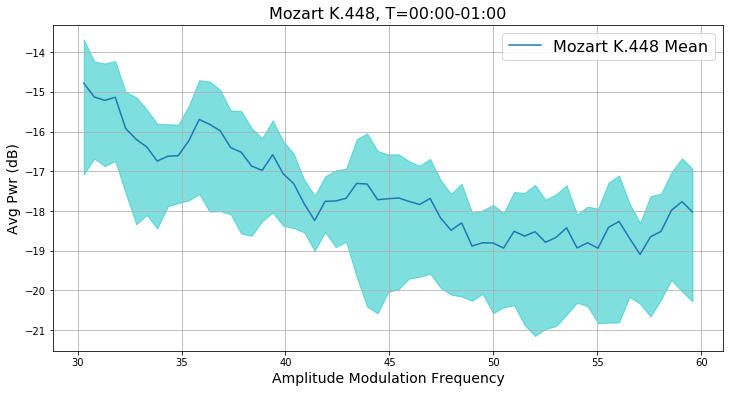

44100 22182300
Loaded /home/mkc/Music/MozartK448_SonataTwoPianosDMaj.wav len: 22182300
sig: win_size=88200, win_shift=44100, sig.shape=2646000,1
n_segments=59
(513, 199, 1)
mod_spec.shape  (59, 513, 199) -> (513, 199)
Freq Range: [1000 3000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (46, 59, 1) (46, 59, 1)
TTEST: (46, 59) (46, 59)
MannwhitneyuResult(statistic=1740.5, pvalue=0.4989262789424854)
(59,) (59,) (59,)


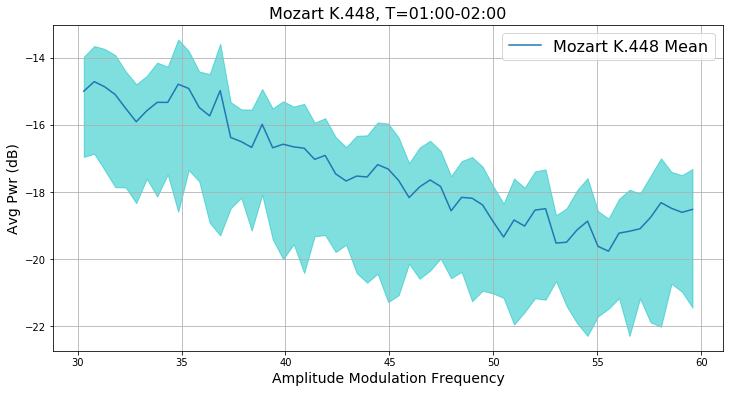

44100 22182300
Loaded /home/mkc/Music/MozartK448_SonataTwoPianosDMaj.wav len: 22182300
sig: win_size=88200, win_shift=44100, sig.shape=2646000,1
n_segments=59
(513, 199, 1)
mod_spec.shape  (59, 513, 199) -> (513, 199)
Freq Range: [1000 3000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (46, 59, 1) (46, 59, 1)
TTEST: (46, 59) (46, 59)
MannwhitneyuResult(statistic=1740.5, pvalue=0.4989262789424854)
(59,) (59,) (59,)


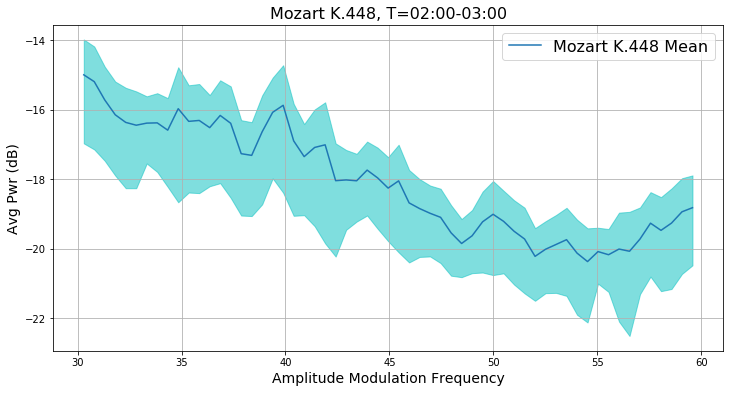

In [140]:
#res_448, w_448 = A.get_mod_spec('/home/mkc/Music/MozartK448_SonataTwoPianosDMaj.wav', avg=True)
res_448, w_448, L, U = get_mod_spec('/home/mkc/Music/MozartK448_SonataTwoPianosDMaj.wav', avg=True)


44100 22182300
Loaded /home/mkc/Music/MozartK448_SonataTwoPianosDMaj.wav len: 22182300
sig: win_size=88200, win_shift=44100, sig.shape=2646000,1
n_segments=59
(513, 199, 1)
mod_spec.shape  (59, 513, 199) -> (513, 199)
Freq Range: [1000 3000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (46, 59, 1) (46, 59, 1)
TTEST: (46, 59) (46, 59)
MannwhitneyuResult(statistic=1594.0, pvalue=0.21598917287022745)
(59,) (59,) (59,)


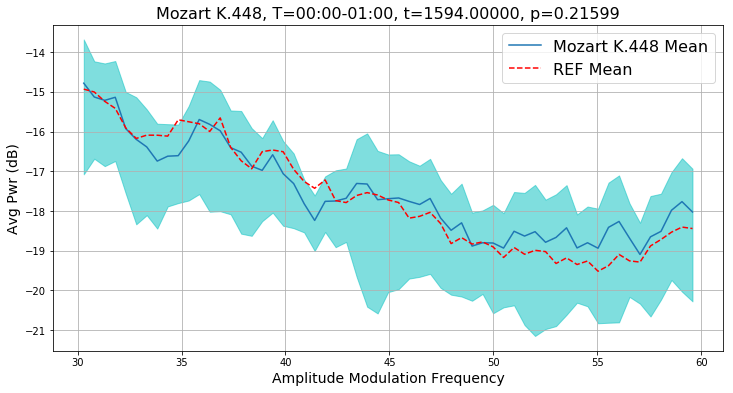

44100 22182300
Loaded /home/mkc/Music/MozartK448_SonataTwoPianosDMaj.wav len: 22182300
sig: win_size=88200, win_shift=44100, sig.shape=2646000,1
n_segments=59
(513, 199, 1)
mod_spec.shape  (59, 513, 199) -> (513, 199)
Freq Range: [1000 3000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (46, 59, 1) (46, 59, 1)
TTEST: (46, 59) (46, 59)
MannwhitneyuResult(statistic=1570.0, pvalue=0.18009970947075593)
(59,) (59,) (59,)


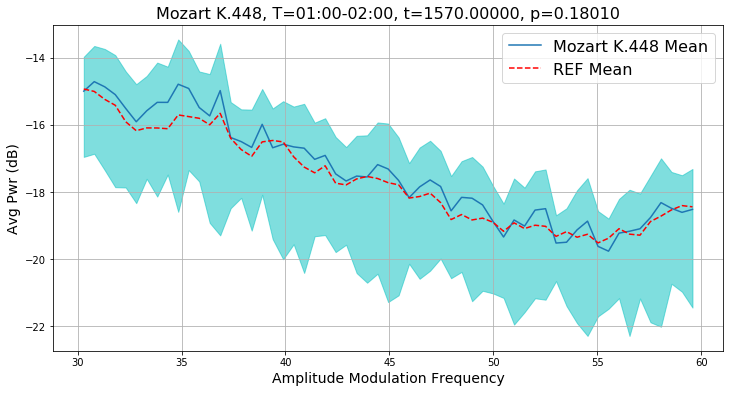

44100 22182300
Loaded /home/mkc/Music/MozartK448_SonataTwoPianosDMaj.wav len: 22182300
sig: win_size=88200, win_shift=44100, sig.shape=2646000,1
n_segments=59
(513, 199, 1)
mod_spec.shape  (59, 513, 199) -> (513, 199)
Freq Range: [1000 3000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (46, 59, 1) (46, 59, 1)
TTEST: (46, 59) (46, 59)
MannwhitneyuResult(statistic=1389.0, pvalue=0.02943417500773737)
(59,) (59,) (59,)


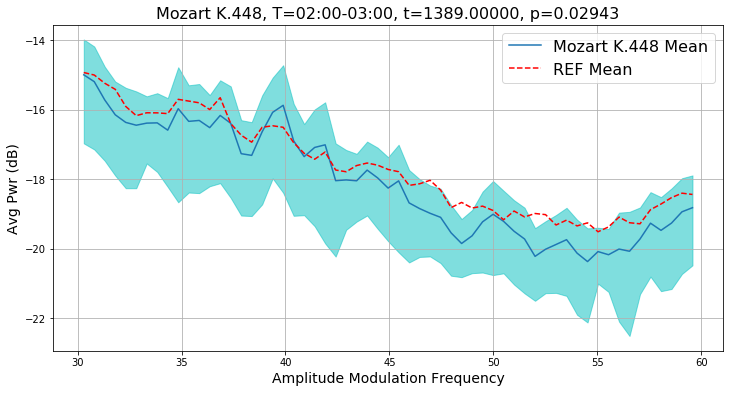

In [141]:
ref_448 = make_reference_mod_spec(res_448)
res_448, w_448, L, U = get_mod_spec(avg=True, ref=ref_448)


44100 4806900
Loaded /home/mkc/Music/Mozart_PianoSonata16CMaj.wav len: 4806900
sig: win_size=88200, win_shift=44100, sig.shape=2646000,1
n_segments=59
(513, 199, 1)
mod_spec.shape  (59, 513, 199) -> (513, 199)
Freq Range: [1000 3000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (46, 59, 1) (46, 59, 1)
TTEST: (46, 59) (46, 59)
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)
(59,) (59,) (59,)


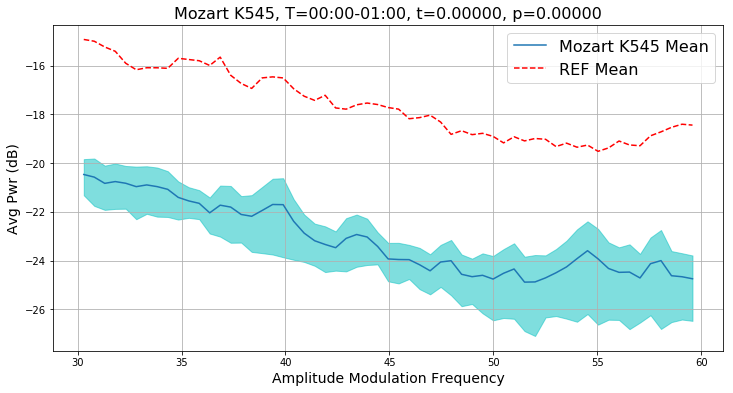

44100 4806900
Loaded /home/mkc/Music/Mozart_PianoSonata16CMaj.wav len: 4806900
sig: win_size=88200, win_shift=44100, sig.shape=2160900,1
n_segments=48
(513, 199, 1)
mod_spec.shape  (48, 513, 199) -> (513, 199)
Freq Range: [1000 3000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (46, 59, 1) (46, 59, 1)
TTEST: (46, 59) (46, 59)
MannwhitneyuResult(statistic=53.0, pvalue=5.434622177562449e-20)
(59,) (59,) (59,)


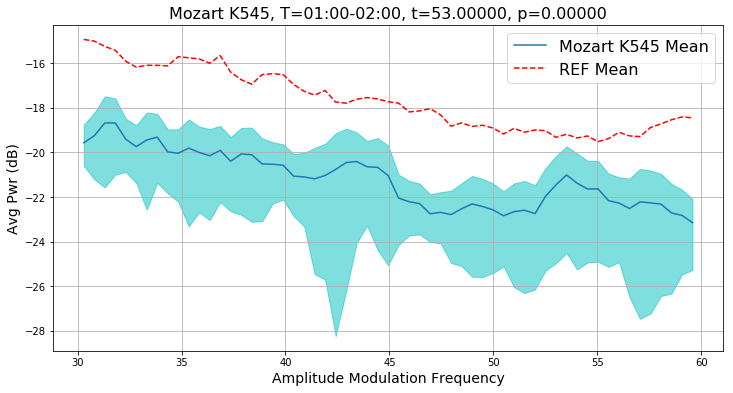

In [142]:
res_545, w_545, L, U = get_mod_spec('/home/mkc/Music/Mozart_PianoSonata16CMaj.wav', ttl='Mozart K545', ref=ref_448, avg=True, T=[0,1])


In [72]:
mod_feat

'power_modulation_spectrogram'

In [76]:
res_448[0].keys()

dict_keys(['rFFT_modulation_spectrogram', 'power_modulation_spectrogram', 'fs', 'fs_mod', 'freq_axis', 'freq_delta', 'freq_mod_axis', 'freq_mod_delta', 'win_size_samples', 'win_shift_samples', 'n_fft_y', 'n_fft_x', 'win_function_y', 'win_function_x', 'n_windows', 'n_samples', 'spectrogram_data', 'channel_names'])